In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from IPython.display import Image as I

# Path planning in complex terrain
### Author Patrik Dominik Pördi

The case description can be seen below.

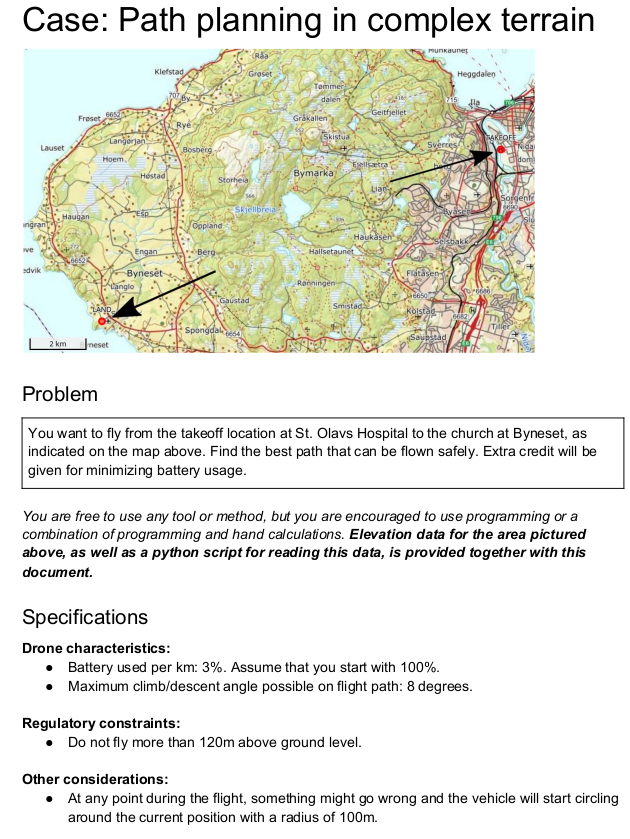

In [13]:
I("case.png")

The provided depth map can be seen below.

Land: 181.62076
Take off: 0.0
Land2: 65.35835
Take off2: 11.908783


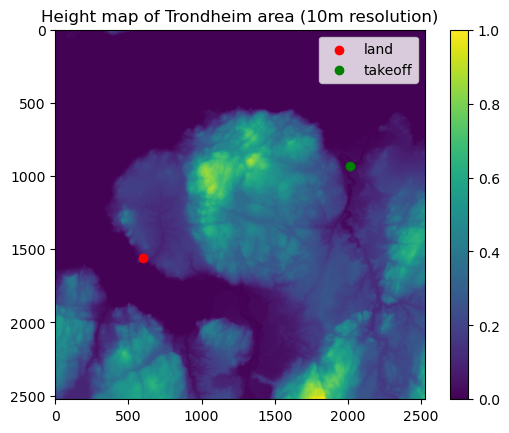

In [14]:
im = Image.open("dtm10_7002_2_10m_z33.tif")

# Reshape to only contain relevant area
w, h = im.size
im = im.crop((0, 0, w / 2, h / 2))

# Load into numpy array
imarray = np.array(im)
print("Land:",imarray[600, 1560])
print("Take off:",imarray[2015, 930])
print("Land2:",imarray[1560,600])
print("Take off2:",imarray[930,2015])

# Plot data
plt.imshow(imarray)
plt.scatter(600, 1560, c="red", label="land")
plt.scatter(2015, 930, c="green", label="takeoff")
plt.legend()
plt.colorbar()
plt.title("Height map of Trondheim area (10m resolution)")
plt.show()

The map is converted into a 3D np.array, where 1-s represent obstacles and 0-s represent the free space. The 10 pixels horizontal clearance is added and a hard deck is set at 10 m height. To be precise all 6 walls should be set to 1, however it would take an even longer time to build the array and the exploration is not likely towards the sides of the map.

In [15]:
array_3d = np.zeros((2560, 2560, np.round(np.max(imarray)).astype(int)+121),dtype=np.uint8)
radius=10
"""Converts the 2d array to a 3d array where obstacles are represented as 1s and free space as 0s"""
for x in range(imarray.shape[0]):
    for y in range(imarray.shape[1]):
        height=np.ceil(imarray[x,y]).astype(int)
        array_3d[x-radius:x+radius+1,y-radius:y+radius+1,:height]=1
        array_3d[x,y,10]=1
        array_3d[x-radius:x+radius+1,y-radius:y+radius+1,height+120]=1

We need to make sure that the given start and goal coordinates are not within the horizontal clearance, if they are, the Z value will be adjusted for safety reasons. The assumption is taken that the drone can hover up vertically to those heights.

In [16]:
def find_max_within_radius(array, x, y, radius):
    """Finds the maximum value within a given radius from a given point"""
    x_start=x - (radius + 1)
    x_end =  x + radius + 1
    y_start = y - (radius + 1)
    y_end = y + radius + 1

    sub_array = array[x_start:x_end, y_start:y_end]
    max_value = int(np.ceil(np.max(sub_array)))
    # Calculate the coordinates of the maximum value in the radius
    coordinate=(x,y,max_value)
    return coordinate

The Takeoff and Lande locations are the following.

In [17]:
start=find_max_within_radius(imarray, 930, 2015, 10)
goal=find_max_within_radius(imarray, 1560,600, 10)
print("Start:{}".format(start))
print("Goal:{}".format(goal))

Start:(930, 2015, 17)
Goal:(1560, 600, 74)


To find the solution A* algorithm was implemented in Python using PriorityQueue, it can be seen below. The algorithm was chosen since finding the optimal solution/ something close to it is crucial in our case, this can be achieved with a proper heuristic function.

For simplicity I discretized the action space, I work with a 24 connected action space, that can be seen below. The maximum height change is 1 m , ~6 deg.

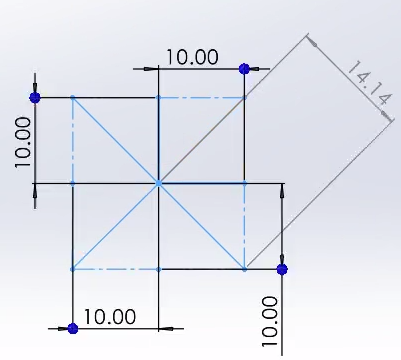

In [18]:
I("4_plane.png")

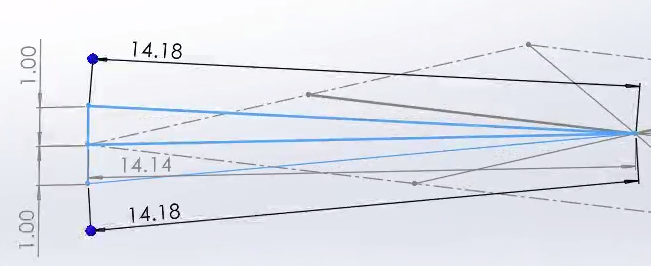

In [19]:
I("8_plane.png")

In [37]:
# Import libraries
import numpy as np
from queue import PriorityQueue
import time

class PathPlanner:
    """Path planner class"""
    def __init__(self, start, goal, map_3d):
        # Initialize variables
        self.start = start
        self.goal = goal
        self.map_3d = map_3d
        self.up_down_move_4_c = np.sqrt(10**2+1.4**2)
        self.plane_move_8_c = np.sqrt(10**2+10**2)
        self.up_down_move_8_c = np.sqrt(self.plane_move_8_c**2+1.4**2)

        # Initialize dictionaries and queue
        self.node = {}
        self.c2c = 0
        self.c2g = self.calc_dist(start, goal)
        self.Q = PriorityQueue()
        self.global_dict = {}
        self.global_dict[start] = [self.c2g + self.c2c, 0, -1, start, self.c2c, self.c2g]
        self.Q.put(self.global_dict[start])
        self.parent = -1
        self.child = 1
        self.closed = {}
        self.path = []
        self.end_time = 0
    
    def calc_dist(self, current, next):
        """Calculate distance between two points"""
        # Calculate distance in 3D space
        d_plane=1.3 * ((current[0] * 10 - next[0] * 10) ** 2 + (current[1] * 10 - next[1] * 10) ** 2)
        d_vertical=(current[2] - next[2]) ** 2
        distance = d_plane + d_vertical
        return distance
    
    def move(self, lst, i, k):
        """Move in 3D space and calculate cost"""
        coords = list(lst[3])
        x_c, y_c, z_c = coords[0], coords[1], coords[2]

        # Calculate new coordinates
        x, y, z = (1, 0, -1, 0, 1, 1, -1, -1), (0, 1, 0, -1, 1, -1, -1, 1), (k, k, k, k, k, k, k, k)
        x_n, y_n, z_n = x_c + x[i], y_c + y[i], z_c + z[i]
        
        # Calculate the length of the move
        if i < 4:
            length = 10 if k == 0 else self.up_down_move_4_c
        else:
            length = self.plane_move_8_c if k == 0 else self.up_down_move_8_c
        
        # Calculate cost
        cost2come = lst[4] + length
        cost2go = self.calc_dist((x_n, y_n, z_n), self.goal)
        cost = cost2go +  600*cost2come #600 is the weight of the cost2come, I tried different values and this heuristic gave the best results
        
        return tuple((x_n, y_n, z_n)), cost, cost2come, cost2go
    
    def plan_path(self):
        """Plan path from start to goal"""
        start_time = time.time()
        
        while True:

            # Check if goal is unreachable
            if self.Q.empty():
                print("Goal is unreachable") 
                self.end_time = time.time()
                break
            
            # Get the  with the lowest cost
            popped = self.Q.get()
            self.node[popped[1]] = [popped[0], popped[2], popped[3], popped[4], popped[5]]
            self.parent = popped[1]
            self.closed[popped[3]] = None

            # Check if goal is reached
            if popped[3] == self.goal:
                g_index = popped[1]
                print("Goal reached:{}".format(popped[3]))
                print("Distance: {:.3f} km".format(popped[4]/1000))
                print("Battery usage: {:.1f} %".format(popped[4]/1000*3))
                self.end_time = time.time()
                break
            
            # Move in 3D space
            for k in [0, 1, -1]:
                for i in range(0, 8):
                    coords, cost, cost2come, cost2go = self.move(popped, i, k)

                    # Check if move is valid
                    if (not self.map_3d[coords]) and (coords not in self.closed):
                        # Check if move is already in queue
                        if coords not in self.global_dict:
                            self.global_dict[coords] = [cost, self.child, self.parent, coords, cost2come, cost2go]
                            self.Q.put(self.global_dict[coords])
                            self.child += 1
                        else:
                            # Check if move is cheaper than previous move
                            if self.global_dict[coords][4] > cost2come:
                                self.global_dict[coords][4] = cost2come
                                self.global_dict[coords][2] = self.parent
                                self.global_dict[coords][0] = cost

        self.end_time = time.time()

        # Backtrack to find path
        while self.node[g_index][1] != -1:
            self.path.append(self.node[g_index][2])
            g_index = self.node[g_index][1]
        self.path.append(self.node[g_index][2])
        self.path.reverse()

        return self.path, self.end_time - start_time


In [38]:

planner = PathPlanner(start, goal, array_3d)
path, execution_time = planner.plan_path()

# print("Path:", path)
print("Algorithm execution Time:", execution_time)

Goal reached:(1560, 600, 74)
Distance: 19.292 km
Battery usage: 57.9 %
Algorithm execution Time: 4.641457796096802


The results can be seen above. There are some additional plots below.

In [39]:
# Extract list of lists from path
list_of_lists = [list(elem) for elem in path]

# Save list to JSON file
with open('my_list.json', 'w') as f:
    json.dump(list_of_lists, f)

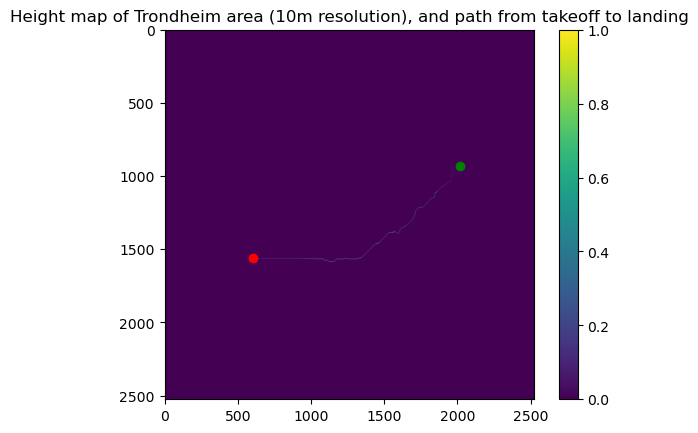

In [40]:
# Plot path on map
array_2d=np.zeros(imarray.shape)
for i in path:
    array_2d[i[0],i[1]]=i[2]

plt.imshow(array_2d)
plt.scatter(600, 1560, c="red", label="land")
plt.scatter(2015, 930, c="green", label="takeoff")
plt.colorbar()
plt.title("Height map of Trondheim area (10m resolution), and path from takeoff to landing")
plt.show()

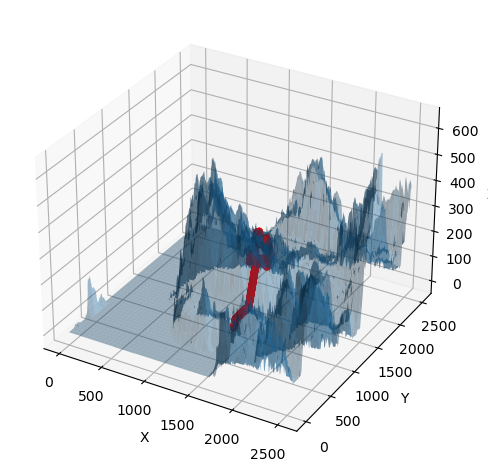

In [41]:
# Plot path in 3D
path=np.array(path)

# create the 3D axis object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# plot the surface
y, x = imarray.shape[0], imarray.shape[1]
x, y = np.meshgrid(np.arange(0, x, 1), np.arange(0, y, 1))
surf = ax.plot_surface(y, x, imarray, alpha=0.4)


# plot the scatter points
ax.scatter(path[:,0], path[:,1], path[:,2], c='r', marker='o')

# plot the lines between the scatter points
for i in range(len(path)-1):
    x = [path[i][0], path[i+1][0]]
    y = [path[i][1], path[i+1][1]]
    z = [path[i][2], path[i+1][2]]
    ax.plot(x, y, z, linewidth=1, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [25]:
import json
# Load list from JSON file and convert back to list of tuples
with open('my_list.json', 'r') as f:
    loaded_list_of_lists = json.load(f)

loaded_list = [tuple(elem) for elem in loaded_list_of_lists]

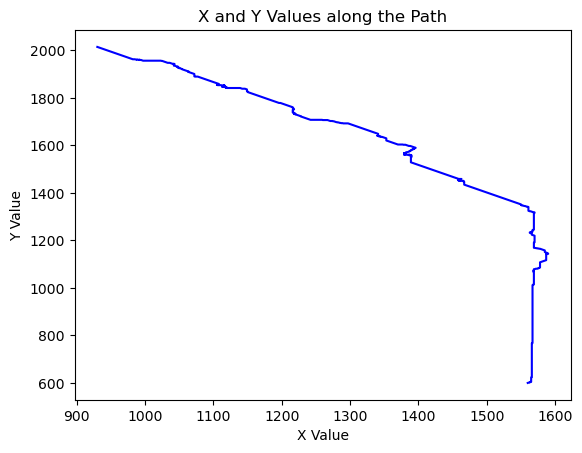

In [26]:
# Plot the x and y values along the path
coordinates = loaded_list
x_values = [coord[0] for coord in coordinates]  # Extract the x values from the coordinates
y_values = [coord[1] for coord in coordinates]  # Extract the y values from the coordinates

plt.plot(x_values, y_values, 'b-')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.title('X and Y Values along the Path')
plt.show()

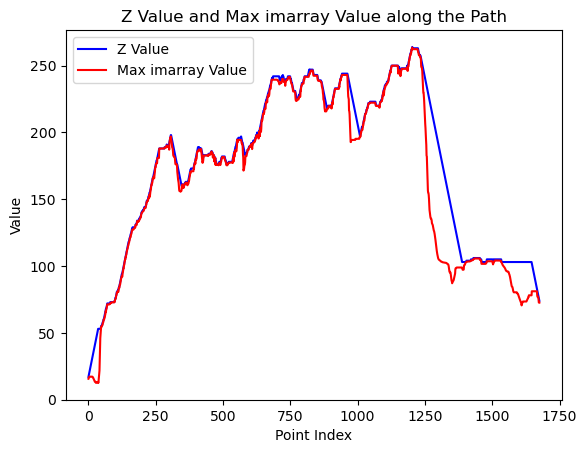

In [27]:
# Plot the z values and max imarray values along the path
coordinates = loaded_list
z_values = [coord[2] for coord in coordinates]  # Extract the z values from the coordinates
max_imarray_values = [np.max(imarray[coord[0]-10:coord[0]+10, coord[1]-10:coord[1]+10]) for coord in coordinates]  # Extract the max values of imarray

plt.plot(range(len(coordinates)), z_values, 'b-', label='Z Value')
plt.plot(range(len(coordinates)), max_imarray_values, 'r-', label='Max imarray Value')
plt.xlabel('Point Index')
plt.ylabel('Value')
plt.title('Z Value and Max imarray Value along the Path')
plt.legend()
plt.show()

You can see that the A* algorithm did not find the optimal solution, therefore the Z values can be smothed.

In [28]:
import numpy as np
import math

# Create a class for the path smoothing algorithm
class SmoothPath:
    # Initialize the class
    def __init__(self, coordinates, array_3d,goal):
        self.coordinates = coordinates
        self.array_3d = array_3d
        self.smooth = []
        self.st_point = None
        self.end_point = None
        self.goal=goal

    # Define a function to calculate the distance between two points
    def Bresenham3D(self, x1, y1, z1, x2, y2, z2):
        """ Bresenham's 3D line algorithm"""
        ListOfPoints = []
        ListOfPoints.append((x1, y1, z1))
        dx = abs(x2 - x1)
        dy = abs(y2 - y1)
        dz = abs(z2 - z1)
        if (x2 > x1):
            xs = 1
        else:
            xs = -1
        if (y2 > y1):
            ys = 1
        else:
            ys = -1
        if (z2 > z1):
            zs = 1
        else:
            zs = -1
     
        # Driving axis is X-axis"
        if (dx >= dy and dx >= dz):       
            p1 = 2 * dy - dx
            p2 = 2 * dz - dx
            while (x1 != x2):
                x1 += xs
                if (p1 >= 0):
                    y1 += ys
                    p1 -= 2 * dx
                if (p2 >= 0):
                    z1 += zs
                    p2 -= 2 * dx
                p1 += 2 * dy
                p2 += 2 * dz
                ListOfPoints.append((x1, y1, z1))
     
        # Driving axis is Y-axis"
        elif (dy >= dx and dy >= dz):      
            p1 = 2 * dx - dy
            p2 = 2 * dz - dy
            while (y1 != y2):
                y1 += ys
                if (p1 >= 0):
                    x1 += xs
                    p1 -= 2 * dy
                if (p2 >= 0):
                    z1 += zs
                    p2 -= 2 * dy
                p1 += 2 * dx
                p2 += 2 * dz
                ListOfPoints.append((x1, y1, z1))
     
        # Driving axis is Z-axis"
        else:       
            p1 = 2 * dy - dz
            p2 = 2 * dx - dz
            while (z1 != z2):
                z1 += zs
                if (p1 >= 0):
                    y1 += ys
                    p1 -= 2 * dz
                if (p2 >= 0):
                    x1 += xs
                    p2 -= 2 * dz
                p1 += 2 * dy
                p2 += 2 * dx
                ListOfPoints.append((x1, y1, z1))
        return ListOfPoints
    
    # Calculate the z angle between two points
    def calculate_z_angle(self, point1, point2):
        dx = point2[0] - point1[0]
        dy = point2[1] - point1[1]
        dz = point2[2] - point1[2]
        
        distance_xy = math.sqrt(dx**2 + dy**2)
        z_angle_rad = math.atan2(dz, distance_xy)
        z_angle_deg = math.degrees(z_angle_rad)
        
        return z_angle_deg
    
    # Smooth the path
    def find_smooth_path(self):
        """Find a smooth path through the coordinates"""
        i=0
        self.st_point = self.coordinates[i]
        self.smooth.append(self.st_point)
        
        # Iterate through all the points in the coordinates list    
        while self.end_point != self.goal: 
            self.end_point = self.coordinates[i+1]
            
            # If the z angle between the two points is less than 8 degrees, check if the path between them is clear
            if self.calculate_z_angle(self.st_point, self.end_point) <= 8:
                rode = self.Bresenham3D(
                self.st_point[0], self.st_point[1], self.st_point[2],
                self.end_point[0], self.end_point[1], self.end_point[2])
                
                # If the path between the two points is clear, add the end point to the smooth path
                if not any(self.array_3d[x, y, z] == 1 for x, y, z in rode):
                    i += 1
                # If the path between the two points is not clear, add the end point to the smooth path
                else:
                    self.st_point = self.coordinates[i]
                    self.smooth.append(self.st_point)
                    self.end_point = self.coordinates[i+1]
                    i += 1
            # If the z angle between the two points is greater than 8 degrees, add the end point to the smooth path
            else:
                self.st_point = self.coordinates[i]
                self.smooth.append(self.st_point)
                self.end_point = self.coordinates[i+1]
                i += 1
        self.smooth.append(self.end_point)
    
    def calc_dist(self, current, next):
        """Calculate distance between two points"""
        # Calculate distance in 3D space
        d_plane = ((current[0] * 10 - next[0] * 10) ** 2 + (current[1] * 10 - next[1] * 10) ** 2)
        d_vertical = (current[2] - next[2]) ** 2
        distance = np.sqrt(d_plane + d_vertical)
        return distance


    def calculate_cost(self):
        """Calculate the cost of the path"""
        cost = 0
        for i in range(len(self.smooth) - 1):
            cost += self.calc_dist(self.smooth[i], self.smooth[i + 1])
        return cost

smooth_path = SmoothPath(coordinates, array_3d,goal)

# Find the smooth path
smooth_path.find_smooth_path()

# Access the smooth path
smooth = smooth_path.smooth

cost = smooth_path.calculate_cost()


print("Goal reached:{}".format(smooth[-1]))
print("Distance: {:.3f} km".format(cost/1000))
print("Battery usage: {:.1f} %".format(cost/1000*3))



Goal reached:(1560, 600, 74)
Distance: 18.775 km
Battery usage: 56.3 %


The improvement can be seen above, while there are some plots below. The path is much smoother. There are less altitude changes.

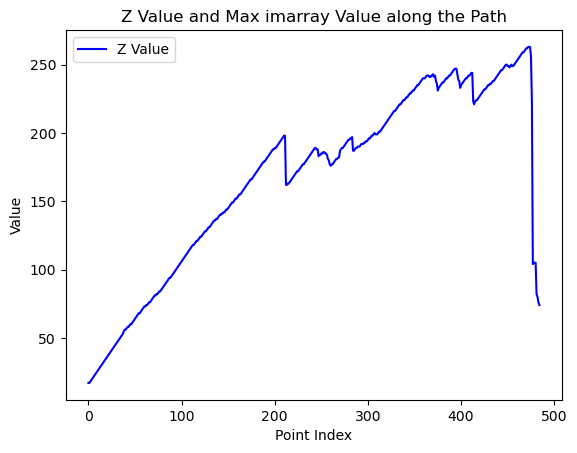

In [29]:
# Plot the smooth Z path
z_values = [coord[2] for coord in smooth]
plt.plot(range(len(smooth)), z_values, 'b-', label='Z Value')

plt.xlabel('Point Index')
plt.ylabel('Value')
plt.title('Z Value and Max imarray Value along the Path')
plt.legend()
plt.show()

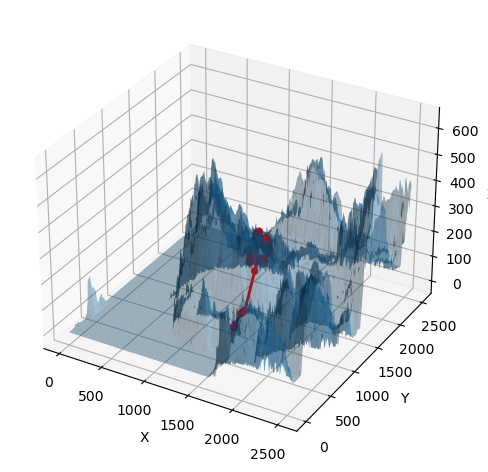

In [30]:
# Plot the smooth path in 3D
path=np.array(smooth)

# create the 3D axis object
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# plot the surface
y, x = imarray.shape[0], imarray.shape[1]
x, y = np.meshgrid(np.arange(0, x, 1), np.arange(0, y, 1))
surf = ax.plot_surface(y, x, imarray, alpha=0.4)


# plot the scatter points
ax.scatter(path[:,0], path[:,1], path[:,2], c='r', marker='o')

# plot the lines between the scatter points
for i in range(len(path)-1):
    x = [path[i][0], path[i+1][0]]
    y = [path[i][1], path[i+1][1]]
    z = [path[i][2], path[i+1][2]]
    ax.plot(x, y, z, linewidth=2, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

Compare the 3D paths.

Before smoothing:

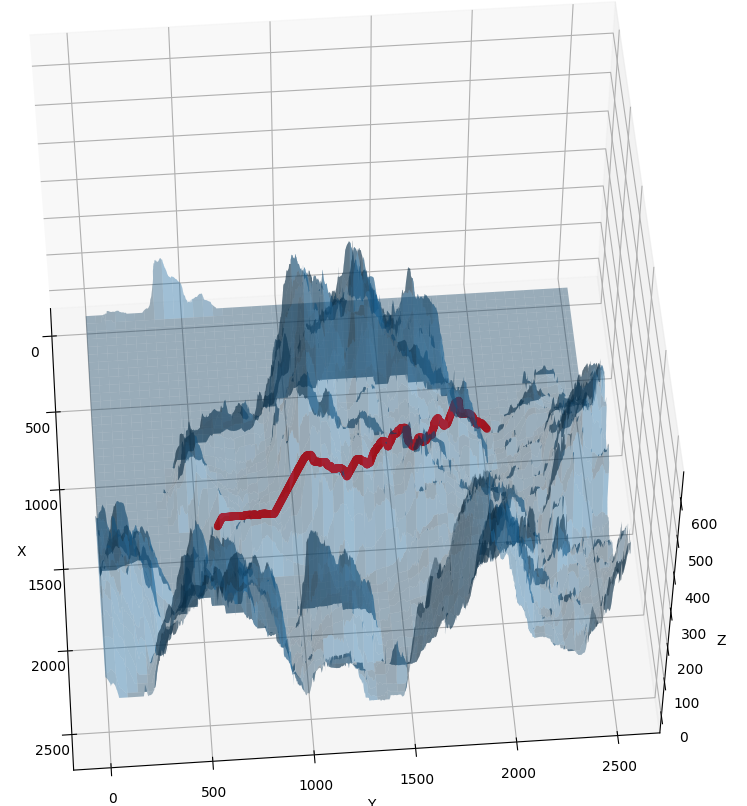

In [31]:
I("way_1_1.png")

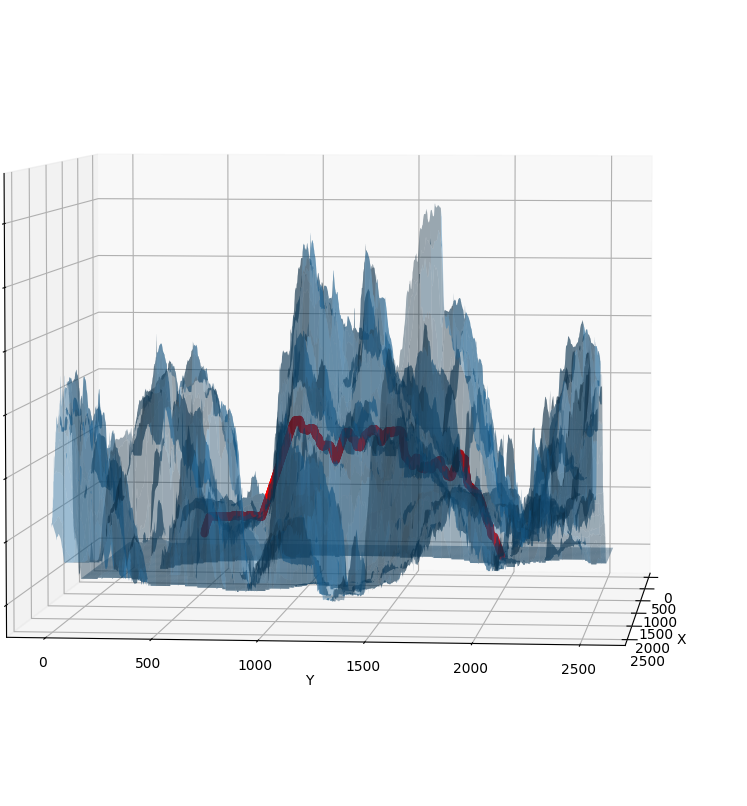

In [32]:
I("way_1_2.png")

After smoothing:

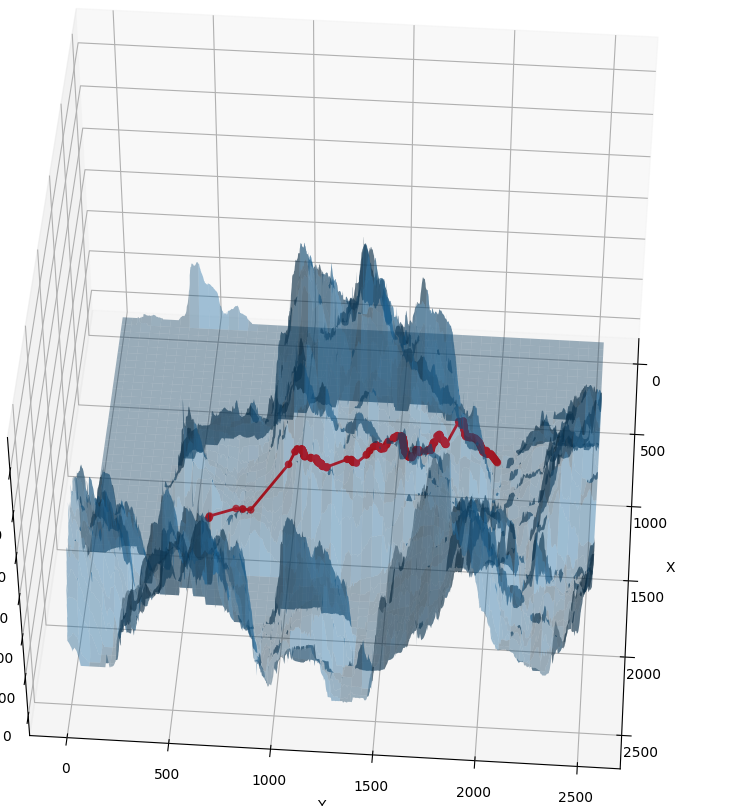

In [33]:
I("way_2_1.png")

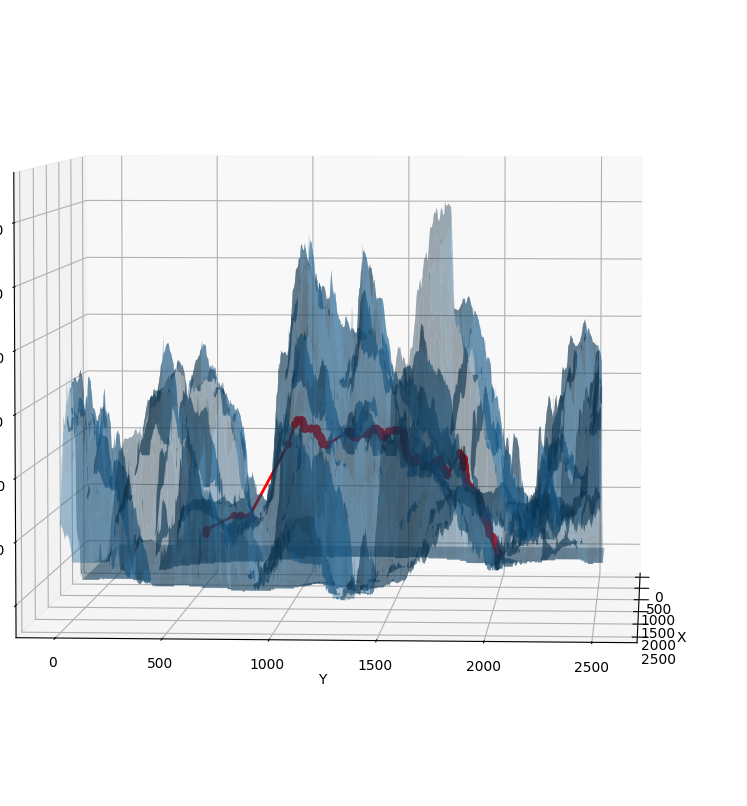

In [34]:
I("way_2_2.png")

Below you can find the implementation of the algorithm using Node class instead of node dictionary. I was not satisfied with the speed, but I already wrote it so I left it here.

In [35]:
import numpy as np
from queue import PriorityQueue
import time

class Node:
    """Node class for A* algorithm"""
    # Initialize the class
    def __init__(self, coordinate, total_cost, c2c, c2g, parent=None):
        self.parent = parent
        self.coordinate = coordinate
        self.total_cost = total_cost
        self.c2c = c2c
        self.c2g = c2g
    # Overload the __lt__ operator
    def __lt__(self, other):
        return self.total_cost < other.total_cost

    

class PathPlanner:
    """Path planner class for A* algorithm"""
    # Initialize the class
    def __init__(self, start, goal, map_3d):
        # Configuration
        self.start = start
        self.goal = goal
        self.map_3d = map_3d
        self.up_down_move_4_c = np.sqrt(10**2+1.4**2)
        self.plane_move_8_c = np.sqrt(10**2+10**2)
        self.up_down_move_8_c = np.sqrt(self.plane_move_8_c**2+1.4**2)

        # Data structures
        self.c2c = 0
        self.c2g = self.calc_dist(start, goal)
        self.Q = PriorityQueue()
        self.global_dict = {}
        start_node=Node(start, self.c2g + self.c2c, self.c2c, self.c2g)
        self.global_dict[start]=start_node
        self.Q.put((start_node.total_cost,start_node))
        self.closed = {}
        self.path = []
        self.end_time = 0
    
    def calc_dist(self, current, next):
        """Calculate distance between two points"""

        # Calculate the distance
        d_plane=1 * ((current[0] * 10 - next[0] * 10) ** 2 + (current[1] * 10 - next[1] * 10) ** 2)
        d_vertical=(current[2] - next[2]) ** 2
        distance = d_plane + d_vertical
        return distance
    
    def move(self, node, i, k):
        """Movees the node in the given direction and calculates the cost"""
        coords = node.coordinate
        x_c, y_c, z_c = coords[0], coords[1], coords[2]

        # Calculate the new coordinates
        x, y, z = (1, 0, -1, 0, 1, 1, -1, -1), (0, 1, 0, -1, 1, -1, -1, 1), (k, k, k, k, k, k, k, k)
        x_n, y_n, z_n = x_c + x[i], y_c + y[i], z_c + z[i]
        
        # Calculate the length of the move
        if i < 4:
            length = 10 if k == 0 else self.up_down_move_4_c
        else:
            length = self.plane_move_8_c if k == 0 else self.up_down_move_8_c
        
        # Calculate the cost
        cost2come = node.c2c + length
        cost2go = self.calc_dist((x_n, y_n, z_n), self.goal)
        cost = cost2go + 600 * cost2come
        
        return Node((x_n, y_n, z_n), cost, cost2come, cost2go, parent=node)
    
    def plan_path(self):
        """Plans the path from start to goal"""
        start_time = time.time()
        
        while True:
            # Check if there are no more nodes to explore,therefor the goal is not reached
            if self.Q.empty():
                print("Goal is unreachable")
                self.end_time = time.time()
                break
            
            # Get the node with the lowest cost
            _, current_node = self.Q.get()
            self.closed[current_node.coordinate]=None

            # Check if the goal is reached
            if current_node.coordinate == self.goal:
                print(current_node.coordinate)
                print("Total cost",current_node.c2c)
                self.end_time = time.time()
                break
            
            # Explore the node in all directions
            for k in [0, 1, -1]:
                for i in range(0, 8):
                    new_node = self.move(current_node, i, k)
                    coords=new_node.coordinate
                    # Check if the node is not in an obstacle and was already explored
                    if (not self.map_3d[coords]) and (coords not in self.closed):
                        if coords not in self.global_dict:
                            # If the node is not in the global dictionary, add it
                            self.global_dict[coords] = new_node
                            self.Q.put((new_node.total_cost, new_node))
                        else:
                            # If the new node is better than the previous one, replace it
                            if self.global_dict[coords].c2c > new_node.c2c:
                                self.global_dict[coords].parent = current_node
                                self.global_dict[coords].c2c = new_node.c2c
                                self.global_dict[coords].total_cost = new_node.total_cost
                                self.Q.put((new_node.total_cost, self.global_dict[coords]))

        # Backtrack to find the path
        value = self.global_dict[self.goal]
        # Go through the parents until the start node is reached
        while value.parent is not None:
            self.path.append(value.coordinate)
            value = value.parent

        # Add the start node
        self.path.append(value.coordinate)
        # Reverse the path
        self.path.reverse()

        return self.path, self.end_time - start_time


In [ ]:
planner = PathPlanner(start, goal, array_3d)
path, execution_time = planner.plan_path()

# print("Path:", path)
print("Execution Time:", execution_time)